# import utilisé dans le programme

In [2]:
#import standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import CNN
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import ResNet50
from keras import Input
from keras import Model
 
#import image
from matplotlib.image import imread
from itertools import chain
import matplotlib.image as mpimg
from io import BytesIO, StringIO
import cv2

import os
from glob import glob

#amazon
import boto3

import time

#classification
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# import PYSPARK

In [3]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

from pyspark.sql.functions import pandas_udf, PandasUDFType, udf, split
from pyspark.sql import Window, SQLContext
from pyspark.sql.types import StructType,StructField, StringType
from pyspark.sql.types import IntegerType, ArrayType, BinaryType, FloatType
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.linalg import Vectors, VectorUDT


log4jLogger = spark.sparkContext._jvm.org.apache.log4j 
log = log4jLogger.LogManager.getLogger(__name__) 

# definition des storages S3 pour les images

In [4]:
s3 = boto3.resource('s3')

In [5]:
#verification liaison S3 OK
for bucket in s3.buckets.all():
    print(bucket.name)

elasticbeanstalk-eu-west-3-636121414640
elp-fruits-data-train1
elp-oc-p8-data
elp-oc-p8-data-20
elp-oc-p8-data-csv
elp-oc-p8-data-preprocess


In [6]:
#compact
bucket_str_data = 'elp-oc-p8-data'
bucket_str_data_upload = 'elp-oc-p8-data-preprocess'
bucket_str_data_csv = 'elp-oc-p8-data-csv'
echantillon = "data_sample_025_020/"

uri_data_S3 = "s3a://"+bucket_str_data+"/"+echantillon
uri_data_upload_S3 = "s3a://"+bucket_str_data_upload+"/"+echantillon

bucket = s3.Bucket(bucket_str_data)
bucket_upload = s3.Bucket(bucket_str_data_upload)
#bucket_csv = s3.Bucket(bucket_str_data_csv)

# chargement des images

In [29]:
#spark._jsc.hadoopConfiguration().set('fs.s3a.access.key', "xxxx")
#spark._jsc.hadoopConfiguration().set('fs.s3a.secret.key', "xxx")
spark._jsc.hadoopConfiguration().set("fs.s3a.aws.credentials.provider", "com.amazonaws.auth.profile.ProfileCredentialsProvider")

In [7]:
img_df = spark.read.format("image").load(uri_data_S3+"Watermelon/8_100.jpg")

In [8]:
img = img_df.select("image.data").take(1)[0][0]

In [9]:
img_rgb = np.array(img).reshape(100,100,3)

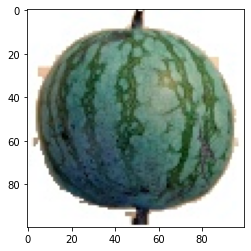

In [10]:
plt.figure(figsize=(4, 4))
plt.imshow(img_rgb)
plt.show()


In [30]:
img_df = spark.read.format("image").load(uri_data_S3+"*/*.jpg")

In [31]:
img_df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



In [32]:
img = img_df.select("image.data").take(1)[0][0]

In [33]:
img_rgb = np.array(img).reshape(100,100,3)

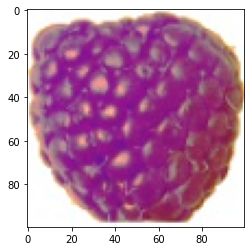

In [34]:
plt.figure(figsize=(4, 4))
plt.imshow(img_rgb)
plt.show()


In [49]:
img_df2 = img_df.withColumn("categ", split("image.origin","/").getItem(4))

In [50]:
img_df3 = img_df2.withColumn("file", split("image.origin","/").getItem(5))

In [51]:
img_df3.select("image.origin", "categ", "file").take(1)

[Row(origin='s3a://elp-oc-p8-data/data_sample_025_020/Raspberry/156_100.jpg', categ='Raspberry', file='156_100.jpg')]

In [52]:
def def_key(categ, file):
    return(categ+"/"+file)

def_key_UDF = udf(def_key, StringType())

In [53]:
img_df4 = img_df3.withColumn("key", def_key_UDF("categ","file"))

In [112]:
img_df4.select('categ', 'file', 'key').take(1)

[Row(categ='Raspberry', file='156_100.jpg', key='Raspberry/156_100.jpg')]

In [54]:
img_df4.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |-- categ: string (nullable = true)
 |-- file: string (nullable = true)
 |-- key: string (nullable = true)



# Preprocess des images 

In [113]:
def preprocess_image(data):
    img_rgb = np.array(data).reshape(100,100,3)
    image_blur = cv2.GaussianBlur(img_rgb, (3, 3), 0)
    image_resize = cv2.resize(image_blur, (224, 224))
    image_retour = cv2.cvtColor(image_resize, cv2.COLOR_BGR2RGB)
    image_flatten = image_retour.flatten()
    image_bytes = image_flatten.tobytes()
    return image_bytes
    
preprocess_imageUDF = udf(preprocess_image, BinaryType())

spark_preproces = img_df4.withColumn("preprocess_data", preprocess_imageUDF("image.data"))

In [56]:
img_preprocess = spark_preproces.select("preprocess_data").take(1)

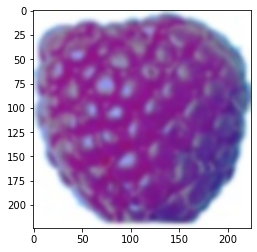

In [57]:
img_preprocess = np.array(img_preprocess[0][0]).reshape(224,224,3)
plt.figure(figsize=(4, 4))
plt.imshow(img_preprocess)
plt.show()


In [58]:
spark_preproces.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |-- categ: string (nullable = true)
 |-- file: string (nullable = true)
 |-- key: string (nullable = true)
 |-- preprocess_data: binary (nullable = true)



In [72]:
def upload_S3(vgg_image, image_key):
    """
        input : ( image a sauver, KEY dans bucket S3 pour sauver )
    """
#    print("envoi : ",image_key)
    image_np = np.array(vgg_image).reshape(224,224,3)

    img_data = BytesIO()
    plt.figure(figsize=(2.24, 2.24), dpi=100, clear=True)
    plt.imshow(image_np)
    plt.axis('off')
    plt.savefig(img_data, format='jpeg', dpi=100)
    img_data.seek(0)
    cle = echantillon+str(image_key)
    bucket_upload.put_object(Body=img_data, ContentType='image/jpeg', Key=cle)
    plt.close()
    
    return "OK"

upload_S3UDF = udf(upload_S3, StringType())




In [66]:
img = spark_preproces.select("preprocess_data", "key").head(1)[0]['preprocess_data']
k = spark_preproces.select("preprocess_data", "key").head(1)[0]['key']

In [67]:
k

'Raspberry/156_100.jpg'

In [74]:
upload_S3(img, k)

'OK'

In [73]:
spark_save = spark_preproces.select("preprocess_data", "key").collect()

In [75]:
for i,elt in enumerate(spark_save):
    if i%50 == 0 : print(i)
    upload_S3(elt['preprocess_data'], elt['key'])

0
50
100
150
200
250
300
350
400
450


# extraction features par transfer learning

In [7]:
#creation liste images
file_s3_upload = []
rep_rech = echantillon+"/*.jpg"
for i,file in enumerate(bucket_upload.objects.filter(Prefix=echantillon)):
    if i%50 == 0 : print(i)
    elt = str(file.key).split("/")[1]
    s3_object = s3.Object(bucket_str_data_upload, file.key)
    image_bytes = s3_object.get()['Body'].read()
    file_s3_upload.append((elt,  file.key, image_bytes))

print(len(file_s3_upload), "images chargées")

0
50
100
150
200
250
300
350
400
450
500 images chargées


In [8]:
df_files3_upload = pd.DataFrame(file_s3_upload, columns=['categ', 'key', 'data'])

In [9]:
df_files3_upload

,categ,key,data
0,Apple_Braeburn,data_sample_025_020/Apple_Braeburn/102_100.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
1,Apple_Braeburn,data_sample_025_020/Apple_Braeburn/118_100.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
2,Apple_Braeburn,data_sample_025_020/Apple_Braeburn/169_100.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
3,Apple_Braeburn,data_sample_025_020/Apple_Braeburn/174_100.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
4,Apple_Braeburn,data_sample_025_020/Apple_Braeburn/189_100.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
...,...,...,...
495,Watermelon,data_sample_025_020/Watermelon/r_302_100.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
496,Watermelon,data_sample_025_020/Watermelon/r_314_100.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
497,Watermelon,data_sample_025_020/Watermelon/r_315_100.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
498,Watermelon,data_sample_025_020/Watermelon/r_37_100.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...


In [10]:
structureSchema = StructType([
         StructField('categ', StringType(), True),
         StructField('key', StringType(), True),
        StructField('image', BinaryType(), True)
         ])

spark_df_files3_upload = spark.createDataFrame(data=df_files3_upload,schema=structureSchema)

In [11]:
spark_df_files3_upload.printSchema()

root
 |-- categ: string (nullable = true)
 |-- key: string (nullable = true)
 |-- image: binary (nullable = true)



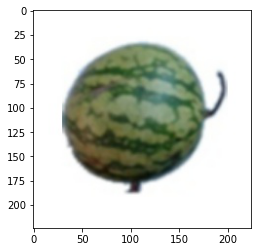

In [12]:
image_orig = spark_df_files3_upload.select("image").head(1)[0][0]
image_RGB = mpimg.imread(BytesIO(image_bytes), 'jpg')
plt.figure(figsize=(4, 4))
plt.imshow(image_RGB)
plt.show()


In [13]:
#utilisation transfer learning pour extraction features 
resnet = ResNet50()
# remove the output layer
model = Model(inputs=resnet.inputs, outputs=resnet.layers[-2].output)
#model.summary()

In [14]:
bc_model_weights = spark.sparkContext.broadcast(model.get_weights())

In [15]:
def model_fn():
    modelvgg = ResNet50(weights=None)
    model = Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-2].output)
    model.set_weights(bc_model_weights.value)
    return model

In [16]:
image_orig = spark_df_files3_upload.select("image").head(1)[0][0]
image_RGB = mpimg.imread(BytesIO(image_bytes), 'jpg')
# convert the image pixels to a numpy array
image = img_to_array(image_RGB)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))


print('image', image.shape)
features = model.predict(image)
print('features', features.shape)


image (1, 224, 224, 3)
features (1, 2048)


In [17]:
@pandas_udf("array<float>")
def func(ser: pd.Series) -> pd.Series:
    mod = model_fn()
    lis = []
    for i in ser:
        image_RGB = mpimg.imread(BytesIO(i), 'jpg')
        image = img_to_array(image_RGB)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        features = mod.predict(image)  
        lis.append(features[0])
    return pd.Series(lis)



In [18]:
spark_df_vgg = spark_df_files3_upload.withColumn("vgg_feat", func("image"))

In [19]:
spark_df_vgg.show()

+--------------+--------------------+--------------------+--------------------+
|         categ|                 key|               image|            vgg_feat|
+--------------+--------------------+--------------------+--------------------+
|Apple_Braeburn|data_sample_025_0...|[FF D8 FF E0 00 1...|[1.6289237, 1.030...|
|Apple_Braeburn|data_sample_025_0...|[FF D8 FF E0 00 1...|[1.8623443, 0.949...|
|Apple_Braeburn|data_sample_025_0...|[FF D8 FF E0 00 1...|[1.1087763, 0.165...|
|Apple_Braeburn|data_sample_025_0...|[FF D8 FF E0 00 1...|[1.1596127, 0.285...|
|Apple_Braeburn|data_sample_025_0...|[FF D8 FF E0 00 1...|[1.3617629, 0.331...|
|Apple_Braeburn|data_sample_025_0...|[FF D8 FF E0 00 1...|[1.119874, 0.4313...|
|Apple_Braeburn|data_sample_025_0...|[FF D8 FF E0 00 1...|[1.4139186, 0.328...|
|Apple_Braeburn|data_sample_025_0...|[FF D8 FF E0 00 1...|[0.89979833, 0.76...|
|Apple_Braeburn|data_sample_025_0...|[FF D8 FF E0 00 1...|[1.0067221, 0.548...|
|Apple_Braeburn|data_sample_025_0...|[FF

In [20]:
spark_df_vgg.printSchema()

root
 |-- categ: string (nullable = true)
 |-- key: string (nullable = true)
 |-- image: binary (nullable = true)
 |-- vgg_feat: array (nullable = true)
 |    |-- element: float (containsNull = true)



In [21]:
to_vector = udf(lambda a: Vectors.dense(a), VectorUDT())

spark_df_vgg_vector = spark_df_vgg.withColumn("vgg_vectores", to_vector("vgg_feat"))

In [22]:
n_components = 20
pca = PCA(
    k = n_components, 
    inputCol = 'vgg_vectores', 
    outputCol = 'pcaFeatures'
).fit(spark_df_vgg_vector)

df_pca = pca.transform(spark_df_vgg_vector)
print('Explained Variance Ratio', pca.explainedVariance.toArray().sum())
df_pca.show(6)

Explained Variance Ratio 0.783493821610616
+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|         categ|                 key|               image|            vgg_feat|        vgg_vectores|         pcaFeatures|
+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Apple_Braeburn|data_sample_025_0...|[FF D8 FF E0 00 1...|[1.6289237, 1.030...|[1.62892365455627...|[11.9149547732828...|
|Apple_Braeburn|data_sample_025_0...|[FF D8 FF E0 00 1...|[1.8623443, 0.949...|[1.86234426498413...|[11.0990851646724...|
|Apple_Braeburn|data_sample_025_0...|[FF D8 FF E0 00 1...|[1.1087763, 0.165...|[1.10877633094787...|[11.6145714117175...|
|Apple_Braeburn|data_sample_025_0...|[FF D8 FF E0 00 1...|[1.1596127, 0.285...|[1.15961265563964...|[11.2803308465362...|
|Apple_Braeburn|data_sample_025_0...|[FF D8 FF E0 00 1...|[1.3617629, 0.331...|[1.36176288127899...|[10

In [23]:
df_pca.printSchema()

root
 |-- categ: string (nullable = true)
 |-- key: string (nullable = true)
 |-- image: binary (nullable = true)
 |-- vgg_feat: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- vgg_vectores: vector (nullable = true)
 |-- pcaFeatures: vector (nullable = true)



In [24]:
from pyspark.ml.functions import vector_to_array

df = df_pca.withColumn('pcaFeatures', vector_to_array('pcaFeatures'))

df.printSchema()

root
 |-- categ: string (nullable = true)
 |-- key: string (nullable = true)
 |-- image: binary (nullable = true)
 |-- vgg_feat: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- vgg_vectores: vector (nullable = true)
 |-- pcaFeatures: array (nullable = false)
 |    |-- element: double (containsNull = false)



In [25]:
df_vgg = df_pca.select('pcaFeatures').toPandas()

In [26]:
def compute_row(row):
    tre = []
    for elt in row.values[0]:
        tre.append(elt)
    return pd.Series(tre)
    
pca_vgg = df_vgg.apply(compute_row, axis=1) 

In [27]:
pca_vgg

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,11.914955,-4.565726,8.945257,-6.039558,-1.819643,-4.896265,-5.207405,-2.189265,-10.404614,-6.083508,-1.069879,-2.464266,-3.925921,-4.120960,-9.821440,-1.480727,-5.630478,-3.977524,-0.316943,-0.358675
1,11.099085,-5.132110,10.065344,-6.698776,-0.659862,-5.302379,-4.776808,-1.928098,-10.984322,-7.001538,-0.805758,-2.742867,-3.464434,-3.281410,-9.957378,-1.143651,-5.827440,-4.722779,-0.017223,-1.014788
2,11.614571,-6.372509,10.585555,-4.354067,0.633991,-8.339223,-7.807793,-5.090651,-13.338077,-4.492315,-0.123943,-2.064063,-5.082400,-3.814596,-7.546392,-3.583546,-3.810953,-3.907462,0.790435,-1.982826
3,11.280331,-5.262006,8.510558,-5.488993,1.215725,-7.660867,-6.481891,-5.040500,-11.753803,-4.080425,-0.357757,-1.893635,-4.810201,-3.803102,-7.749589,-3.308099,-4.319713,-3.445300,0.309754,-1.285666
4,10.752704,-2.691087,6.132481,-6.412728,-1.162042,-6.893063,-3.784796,-3.830927,-9.683468,-3.414769,-1.429363,-0.463016,-4.981149,-4.179315,-5.737952,-3.270420,-4.393901,-2.985263,-0.274915,-0.924865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-7.225203,-8.856427,-6.573380,-4.400471,0.489376,-7.771990,-3.109153,3.072541,-14.420334,-6.865970,1.842659,-1.901602,-2.081099,-3.235511,-0.344483,-4.607528,-5.892707,-5.202084,1.931130,-3.591161
496,-7.178321,-9.283623,-6.331691,-4.460455,1.806390,-7.212052,-3.363192,2.774378,-13.531912,-6.359366,2.597042,-1.737914,-1.318608,-3.325211,-0.767127,-5.078394,-6.164553,-4.628039,1.983226,-4.273215
497,-7.259496,-9.447846,-6.411181,-4.909516,1.492770,-8.271549,-3.601228,3.164350,-14.027813,-6.835977,2.540107,-1.897280,-1.526337,-3.319665,-0.472800,-5.392387,-6.336938,-4.508797,2.245136,-4.381052
498,-5.690784,-7.119770,-4.880719,-1.855201,0.803119,-7.072410,-0.919229,0.878599,-10.247360,-3.064323,2.372772,-1.077769,-1.630135,-2.304867,-0.813391,-5.640364,-4.857626,-4.299011,1.668977,-3.373375


In [28]:
csv_buffer = StringIO()
pca_vgg.to_csv(csv_buffer, sep=';')
s3_resource = boto3.resource('s3')
file_csv = echantillon+'df_features_pca.csv'
s3_resource.Object(bucket_str_data_csv, file_csv).put(Body=csv_buffer.getvalue())


{'ResponseMetadata': {'RequestId': 'A7X6XRD725S1TH73',
  'HostId': 'cAv9Nescj45zfpq+wSjxoTw+Gz2YHUPSOC3Pb8nXXsYDO+X6qnNCbAwsO4b0bdExJ6Stote76P4=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'cAv9Nescj45zfpq+wSjxoTw+Gz2YHUPSOC3Pb8nXXsYDO+X6qnNCbAwsO4b0bdExJ6Stote76P4=',
   'x-amz-request-id': 'A7X6XRD725S1TH73',
   'date': 'Thu, 16 Sep 2021 17:21:01 GMT',
   'etag': '"565d7e891a5697253bae1f26d2735902"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"565d7e891a5697253bae1f26d2735902"'}

In [29]:
df_categ = df_pca.select('categ', 'key').toPandas()

In [30]:
df_categ

,categ,key
0,Apple_Braeburn,data_sample_025_020/Apple_Braeburn/102_100.jpg
1,Apple_Braeburn,data_sample_025_020/Apple_Braeburn/118_100.jpg
2,Apple_Braeburn,data_sample_025_020/Apple_Braeburn/169_100.jpg
3,Apple_Braeburn,data_sample_025_020/Apple_Braeburn/174_100.jpg
4,Apple_Braeburn,data_sample_025_020/Apple_Braeburn/189_100.jpg
...,...,...
495,Watermelon,data_sample_025_020/Watermelon/r_302_100.jpg
496,Watermelon,data_sample_025_020/Watermelon/r_314_100.jpg
497,Watermelon,data_sample_025_020/Watermelon/r_315_100.jpg
498,Watermelon,data_sample_025_020/Watermelon/r_37_100.jpg


In [31]:
csv_buffer = StringIO()
df_categ.to_csv(csv_buffer, sep=';')
s3_resource = boto3.resource('s3')
file_csv = echantillon+'df_categ.csv'
s3_resource.Object(bucket_str_data_csv, file_csv).put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'A7X06TZT8HBQ4TNZ',
  'HostId': 'TJ8bdzR2QCAE0GGL7Hiz0yE6JSfIE+Br5tgIniYN13VTH3PqUyaVCYDmtza4xp8O0f4cXRQC6ns=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'TJ8bdzR2QCAE0GGL7Hiz0yE6JSfIE+Br5tgIniYN13VTH3PqUyaVCYDmtza4xp8O0f4cXRQC6ns=',
   'x-amz-request-id': 'A7X06TZT8HBQ4TNZ',
   'date': 'Thu, 16 Sep 2021 17:21:01 GMT',
   'etag': '"ebb2cbba10271104118f46841b7faa9a"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"ebb2cbba10271104118f46841b7faa9a"'}

# suite pour classification et affichage non demandé

### Kmeans pour classifier

In [32]:
km_acp = KMeans(n_clusters=20)
km_acp.fit(pca_vgg)


KMeans(n_clusters=20)

In [33]:
from sklearn.metrics.cluster import adjusted_rand_score

adjusted_rand_score(km_acp.labels_, df_categ.categ)

0.5345438110013071

### PCA 2 dimension et TSNE pour affichage

In [34]:
n_components = 2
pca = PCA(
    k = n_components, 
    inputCol = 'vgg_vectores', 
    outputCol = 'pca2D'
).fit(spark_df_vgg_vector)

df_affic = pca.transform(spark_df_vgg_vector)
print('Explained Variance Ratio', pca.explainedVariance.toArray().sum())
df_affic.show(6)

Explained Variance Ratio 0.2691060478693897
+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|         categ|                 key|               image|            vgg_feat|        vgg_vectores|               pca2D|
+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Apple_Braeburn|data_sample_025_0...|[FF D8 FF E0 00 1...|[1.6289237, 1.030...|[1.62892365455627...|[11.9149547732828...|
|Apple_Braeburn|data_sample_025_0...|[FF D8 FF E0 00 1...|[1.8623443, 0.949...|[1.86234426498413...|[11.0990851646723...|
|Apple_Braeburn|data_sample_025_0...|[FF D8 FF E0 00 1...|[1.1087763, 0.165...|[1.10877633094787...|[11.6145714117175...|
|Apple_Braeburn|data_sample_025_0...|[FF D8 FF E0 00 1...|[1.1596127, 0.285...|[1.15961265563964...|[11.2803308465362...|
|Apple_Braeburn|data_sample_025_0...|[FF D8 FF E0 00 1...|[1.3617629, 0.331...|[1.36176288127899...|[1

In [35]:
df_vgg = df_affic.select('pca2D').toPandas()
pca_affic = df_vgg.apply(compute_row, axis=1) 
pca_affic.columns=['X','Y']
pca_affic

,X,Y
0,11.914955,-4.565726
1,11.099085,-5.132110
2,11.614571,-6.372509
3,11.280331,-5.262006
4,10.752704,-2.691087
...,...,...
495,-7.225203,-8.856427
496,-7.178321,-9.283623
497,-7.259496,-9.447846
498,-5.690784,-7.119770


In [36]:
csv_buffer = StringIO()
pca_affic.to_csv(csv_buffer, sep=';')
s3_resource = boto3.resource('s3')
file_csv = echantillon+'df_features_pca_affichage2D.csv'
s3_resource.Object(bucket_str_data_csv, file_csv).put(Body=csv_buffer.getvalue())


{'ResponseMetadata': {'RequestId': 'J067GA1BJNF4D8K9',
  'HostId': '8/cnT9/cucgDfwBAmZzgIqLj7qcgkEUEcGdHYkYnDIfyPiEyTGI5AIP3etfT6KcKnIkiwuk6zrI=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '8/cnT9/cucgDfwBAmZzgIqLj7qcgkEUEcGdHYkYnDIfyPiEyTGI5AIP3etfT6KcKnIkiwuk6zrI=',
   'x-amz-request-id': 'J067GA1BJNF4D8K9',
   'date': 'Thu, 16 Sep 2021 17:27:58 GMT',
   'etag': '"1c246fe0d74674d7e8a38959f6041ad3"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"1c246fe0d74674d7e8a38959f6041ad3"'}

In [37]:
tsne = TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=1944)

X_tsne_sift = tsne.fit_transform(pca_vgg)
df_tsne_sift = pd.DataFrame(X_tsne_sift[:,0:2], columns=['tsne1', 'tsne2'])
print(X_tsne_sift.shape)


(500, 2)


In [38]:
csv_buffer = StringIO()
df_tsne_sift.to_csv(csv_buffer, sep=';')
s3_resource = boto3.resource('s3')
file_csv = echantillon+'df_features_tsne_affichage2D.csv'
s3_resource.Object(bucket_str_data_csv, file_csv).put(Body=csv_buffer.getvalue())


{'ResponseMetadata': {'RequestId': '10WQGYWPKW7SADGS',
  'HostId': 'uAfP4mi2PUjoO4QZil2E66UJGCsl2PHkn2O9Vffvr/ZKBBpWSQn+igMm0pB1JnmLeevgPERgcsc=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'uAfP4mi2PUjoO4QZil2E66UJGCsl2PHkn2O9Vffvr/ZKBBpWSQn+igMm0pB1JnmLeevgPERgcsc=',
   'x-amz-request-id': '10WQGYWPKW7SADGS',
   'date': 'Thu, 16 Sep 2021 17:28:02 GMT',
   'etag': '"c2bd31e9293e782f015d4a3218245edc"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"c2bd31e9293e782f015d4a3218245edc"'}

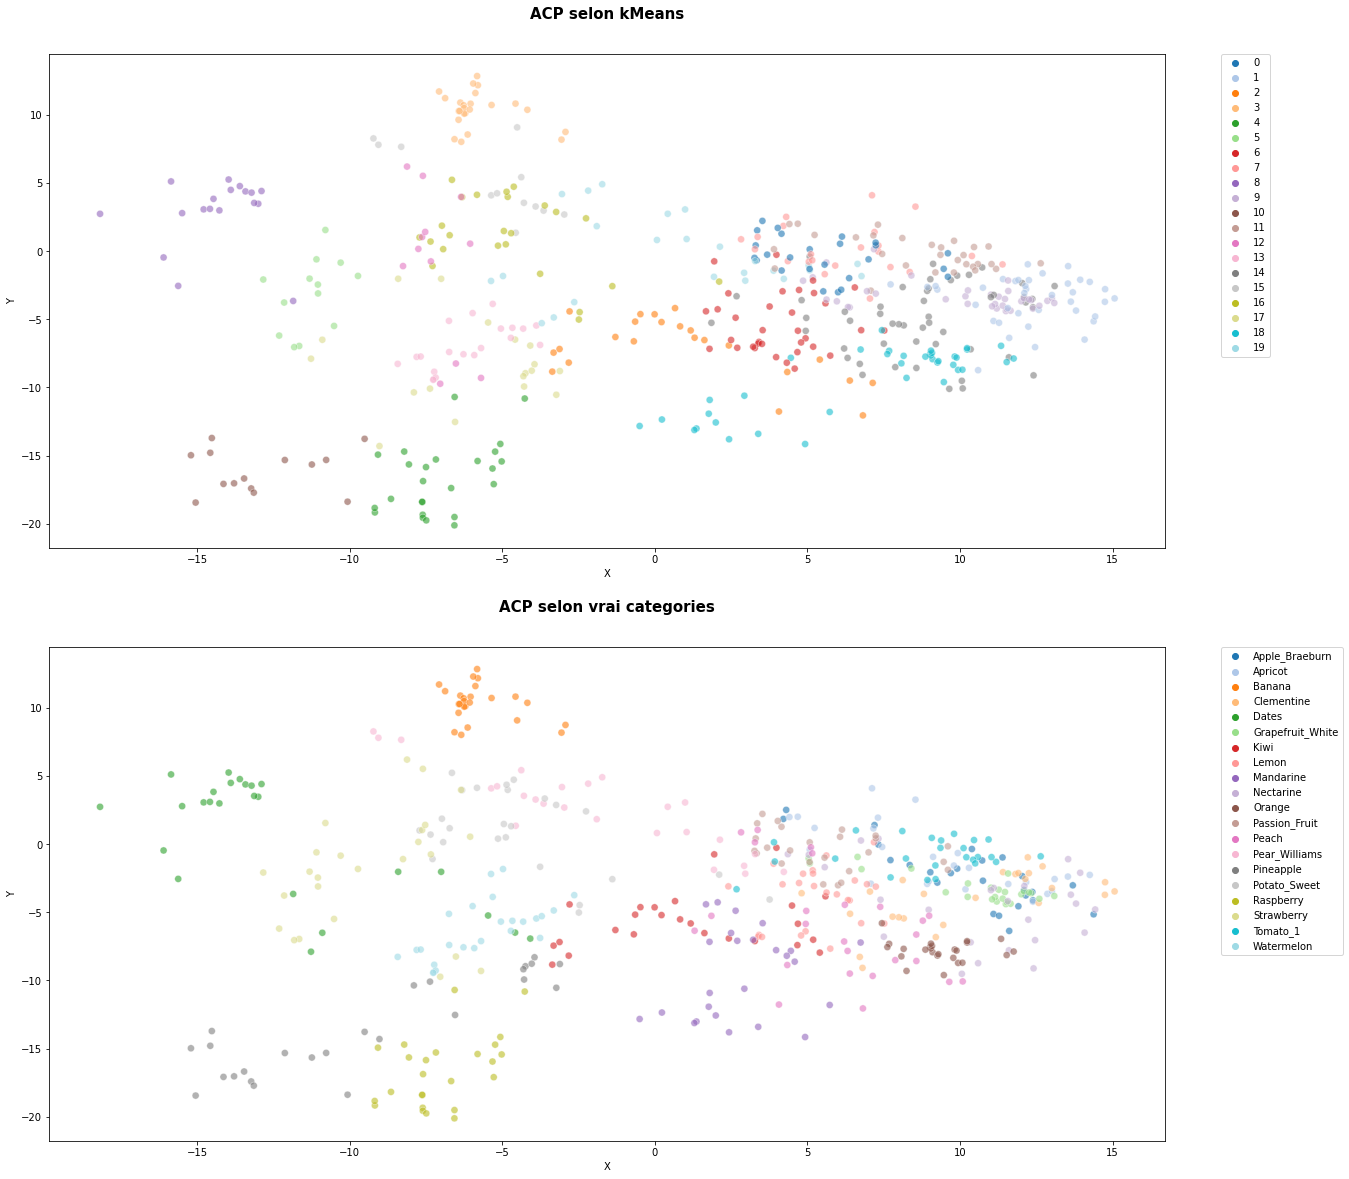

In [39]:
plt.figure(figsize=(20,20))

plt.subplot(2,1,1)
sns.scatterplot(   x=pca_affic.X, y=pca_affic.Y, legend="brief", hue=km_acp.labels_, s=50, alpha=0.6, palette='tab20')
plt.title('ACP selon kMeans', fontsize = 15, pad = 35, fontweight = 'bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.subplot(2,1,2)
sns.scatterplot(   x=pca_affic.X, y=pca_affic.Y, legend="brief", hue=df_categ.categ, s=50, alpha=0.6, palette='tab20')
plt.title('ACP selon vrai categories', fontsize = 15, pad = 35, fontweight = 'bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

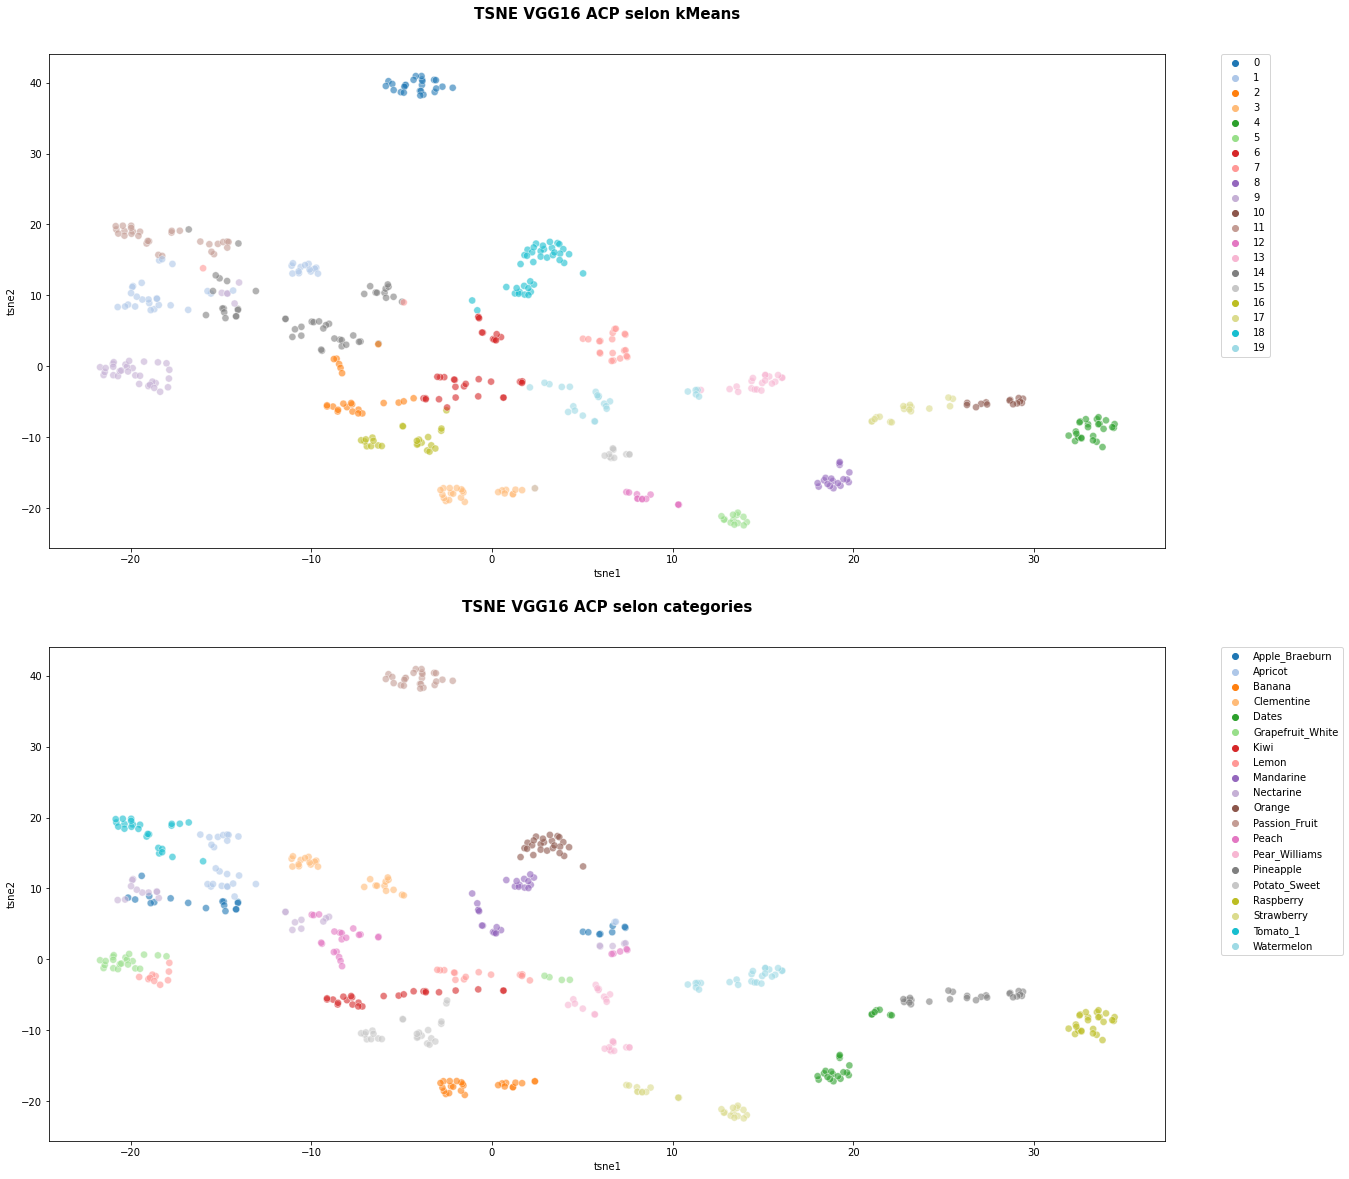

In [41]:
plt.figure(figsize=(20, 20))

plt.subplot(2,1,1)
sns.scatterplot(   x="tsne1", y="tsne2", data=df_tsne_sift, legend="brief", hue=km_acp.labels_, s=50, alpha=0.6, palette='tab20')
plt.title('TSNE VGG16 ACP selon kMeans', fontsize = 15, pad = 35, fontweight = 'bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.subplot(2,1,2)
sns.scatterplot(   x="tsne1", y="tsne2", data=df_tsne_sift, legend="brief", hue=df_categ.categ, s=50, alpha=0.6, palette='tab20')
plt.title('TSNE VGG16 ACP selon categories', fontsize = 15, pad = 35, fontweight = 'bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()